<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SampleInfo1     1404 non-null   object        
 1   Wrk             1404 non-null   object        
 2   Sample          1404 non-null   object        
 3   Batch           1404 non-null   object        
 4   Analysis        1404 non-null   object        
 5   Analyte         1404 non-null   object        
 6   nResult         1404 non-null   float64       
 7   nMDL            1404 non-null   float64       
 8   nMRL            1404 non-null   float64       
 9   LR              1404 non-null   float64       
 10  FinalUnits      1404 non-null   object        
 11  AnalyteNotes    1404 non-null   object        
 12  Qualifier       77 non-null     object        
 13  TextBody        77 non-null     object        
 14  SampleReceived  1404 non-null   datetime64[ns]
 15  Anal

C:\Users\cyu\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cyu\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


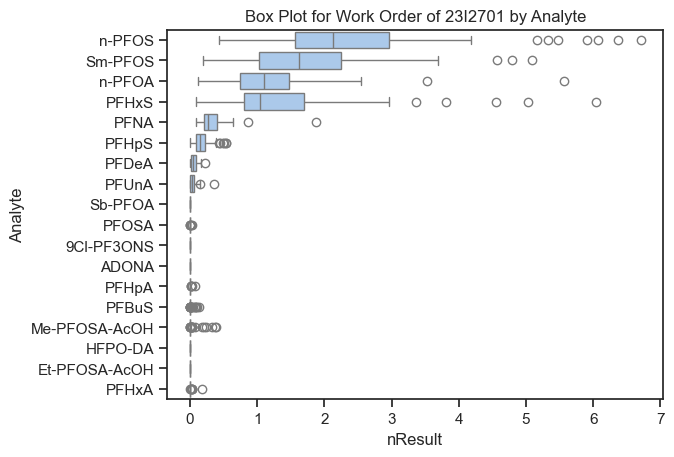

C:\Users\cyu\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cyu\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\_oldcore.py:1124: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


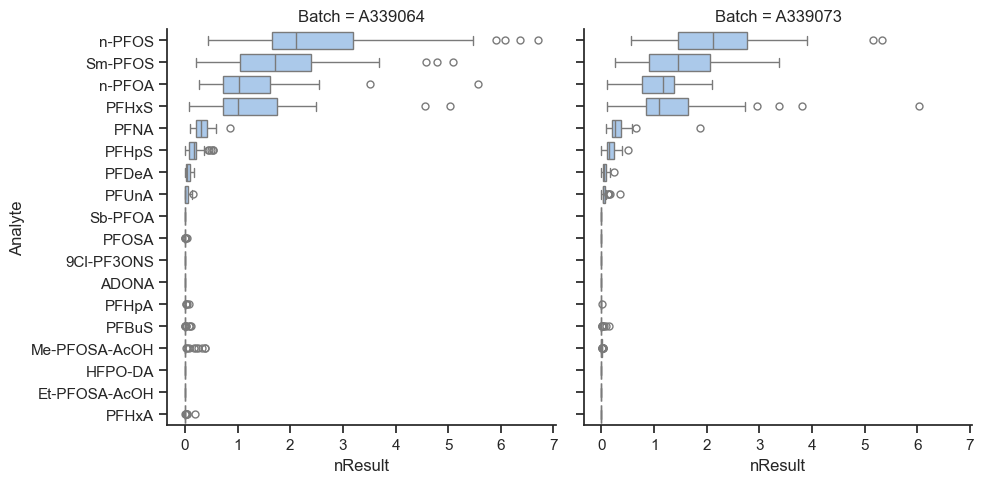

C:\Users\cyu\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


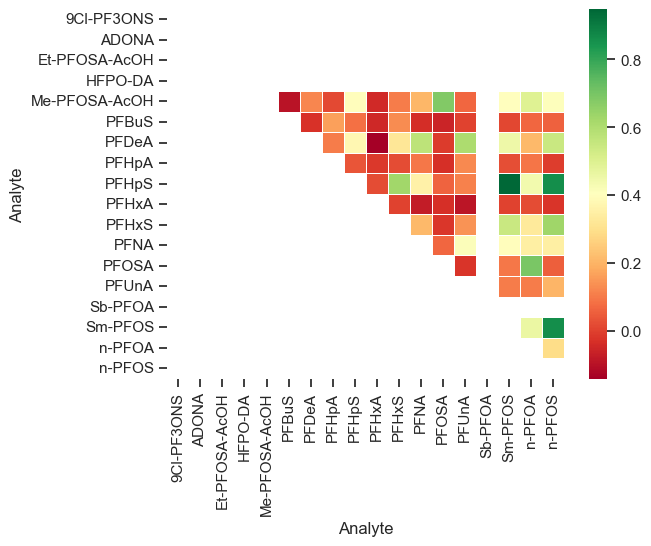

In [1]:
# Create LogStatus table from ELEMENT DB using an ODBC connection through SQLAlchemy
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
server = 'DOH-LAB-04\ELEMENT,1493'
database = 'LTDB'
engine = create_engine('mssql+pyodbc://' + server + '/' + database + '?trusted_connection=yes&driver=SQL+Server', use_setinputsizes=False)
work = '23I2701'
query = (
         "select distinct s.SampleInfo1, a.Wrk, a.Sample, n.Batch, a.Analysis, a.Analyte, a.nResult, a.nMDL, a.nMRL, l.LR, a.FinalUnits, a.AnalyteNotes, q.Qualifier, q.TextBody, s.SampleReceived, a.Analyzed "
         "from LTDB.dbo.WRKSAMPLE s "
         "inner join LTDB.dbo.REPSAMPLEANALYTE a "
         "on s.Wrk=a.Wrk and s.Sample=a.Sample "
         "inner join LTDB.dbo.REPSAMPLEANALYSIS n "
         "on a.Wrk=n.Wrk and a.Sample=n.Sample "
         "inner join LTDB.dbo.ANALYSISLIMITSET l "
         "on a.Analysis=l.Analysis and a.Analyte=l.Analyte "
         "left join LTDB.dbo.REPQUALIFIER q "
         "on a.Wrk=q.Wrk and a.Sample=q.Sample and a.Analyte=q.Analyte "
         "where a.Wrk='" +work+ "' order by Wrk, Sample, Analyte"
        )
df = pd.read_sql(query, engine)
from datetime import datetime
today = datetime.today().strftime('%m%d%y')
#df.to_csv('V:\\Biomonitoring Grant-CDC 2019-2024\\University of Arizona\\Firefighter Full Project\\'+work+'_P-'+datetime.today().strftime('%m%d%y')+'.csv')

# Let's do simple exploratory data analysis (EDA) for the loaded data set.
df.head()
df.tail()
#df.shape()
df.info()
df.describe()
df.dtypes

# Subset ELEMENT data with limited variables to further explore
df2 = df[['Wrk', 'Sample', 'Batch', 'Analysis', 'Analyte', 'nResult']]
Unique = df2.nunique()
Unique2 = Unique.to_frame()
import dataframe_image as dfi
df_styled = Unique2.style.background_gradient()
#dfi.export(df_styled,'V:\\Biomonitoring Grant-CDC 2019-2024\\University of Arizona\\Firefighter Full Project\\'+work+'-Unique Count-'+datetime.today().strftime('%m%d%y')+'.png')

# Static image for documentation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="pastel")
order = df2.groupby('Analyte')['nResult'].median().sort_values(ascending=False).index
sns.boxplot(data=df2, y="Analyte", x="nResult", order=order).set(title='Box Plot for Work Order of '+work+' by Analyte')
plt.show()
sns.catplot(data=df2, y="Analyte", x="nResult", order=order, kind="box", col="Batch", col_wrap=2)
plt.show()

# Prepare subset data for seaborn heatmapping
df3 = df2[['Sample', 'Analyte', 'nResult']]
df3 = df3.pivot(index='Sample', columns='Analyte', values='nResult')
corr_mx = df3.corr() # correlation matrix
matrix = np.tril(corr_mx) # take lower correlation matrix
sns.heatmap(corr_mx, mask=matrix, annot=True, fmt='.2f', cmap='RdYlGn', linewidth=.5, annot_kws={"fontsize":6})

# Interactive image on browser with hovering individual data
import plotly
import plotly.io as pio
import plotly.express as px
pio.renderers.default='browser'
fig = px.box(df2, x="nResult", y="Analyte", hover_data=["Sample"], points='all', title='Interactive Box Plot for Work Order of '+work+' by Analyte')
fig.update_yaxes(categoryorder='median ascending')
fig.show()